# Context-aware drift detection on ECGs

### Introduction

In this notebook we show how to **detect drift on ECG data given a specific context** using the [context-aware MMD detector](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/contextmmddrift.html). Consider the following simple example: we have a heatbeat monitoring system which is trained on a wide variety of heartbeats sampled from people of all ages across a variety of activities (e.g. rest or running). Then we deploy the system to monitor individual people during certain activities. The distribution of the heartbeats monitored during deployment will then be drifting against the reference data which resembles the full training distribution, simply because only individual people in a specific setting are being tracked. However, this does not mean that the system is not working and requires re-training. We are instead interested in flagging drift given the relevant context such as the person's characteristics (e.g. age or medical history) and the activity. Traditional drift detectors cannot flexibly deal with this setting since they rely on the [i.i.d.]([i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)) assumption when sampling the reference and test sets. The context-aware detector however allows us to pass this context to the detector and flag drift appropriately. More generally, **the context-aware drift detector can detect changes in the data distribution which cannot be attributed to a change in the context variable, which we deem permissible**. On top of that, the detector allows you to understand which subpopulations are present in both the reference and test data which provides deeper insights into the distribution underlying the test data.

Useful context (or *conditioning*) variables for the context-aware drift detector include but are not limited to:
1. **Domain or application specific** contexts such as the time of day or the activity (e.g. running or resting).
2. Conditioning on the **relative prevalences of known subpopulations**, such as the frequency of different types of heartbeats. It is important to note that while the relative frequency of each subpopulation (e.g. the different heartbeat types) might change, the distribution of each individual subpopulation (e.g. each specific type of heartbeat) cannot change.
3. Conditioning on **model predictions**. Assume we trained a classifier which detects arrhythmia, then we can provide the classifier model predictions as context and understand if, given the model prediction, the data comes from the same underlying distribution as the reference data or not.
4. Conditioning on **model uncertainties** which would allow increases in model uncertainty due to drift into familiar regions of high aleatoric uncertainty (often fine) to be distinguished from that into unfamiliar regions of high epistemic uncertainty (often problematic).

The following settings will be showcased throughout the notebook:
1. A **relative change in prevalence of subpopulations** (i.e. different types of heartbeats as determined by an unsupervised clustering model or an ECG classifier) which are also present in the reference data is observed. Contrary to traditional drift detection approaches, **the context-aware detector does not flag drift** as this change in frequency of various heartbeats is permissible given the context provided.
2. A **change in the underlying distribution of one or more subpopulations** takes place. While we allow changes in the prevalence of the subpopulations accounted for by the context variable, we do not allow changes of the subpopulations themselves. If for instance the ECGs are corrupted by noise on the sensor measurements, we want to flag drift.

The drift detector will be conditioned on the ECG classifier model predictions, cluster membership by an unsupervised clustering algorithm and time. 

Under setting 1. we want our detector to be **well-calibrated** (a controlled False Positive Rate (FPR) and more generally a p-value which is uniformly distributed between 0 and 1) while under setting 2. we want our detector to be **powerful** and flag drift. Lastly, we show how the detector can help you to **understand the connection between the reference and test data distributions** better.

### Data

The dataset contains 5000 ECG’s, originally obtained from Physionet from the [BIDMC Congestive Heart Failure Database](https://www.physionet.org/content/chfdb/1.0.0/), record chf07. The data has been pre-processed in 2 steps: first each heartbeat is extracted, and then each beat is made equal length via interpolation. The data is labeled and contains 5 classes. The first class $N$ which contains almost 60% of the observations is seen as normal while the others are *supraventricular ectopic beats* ($S$), *ventricular ectopic beats* ($V$), *fusion beats* ($F$) and *unknown beats* ($Q$).

### Requirements

The notebook requires the `torch` and `statsmodels` packages to be installed, which can be done via `pip`:

In [ ]:
!pip install torch statsmodels

Before we start let's fix the random seeds for reproducibility:

In [1]:
import numpy as np
import torch

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed(2022)

## Load data

First we load the data, show the distribution across the ECG classes and visualise some ECGs from each class.

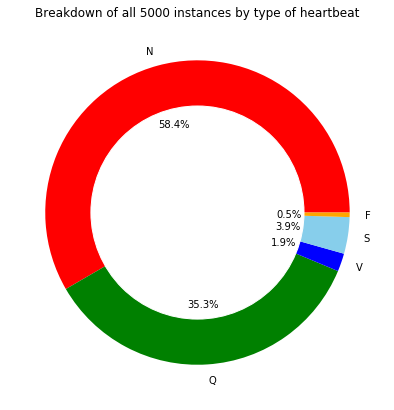

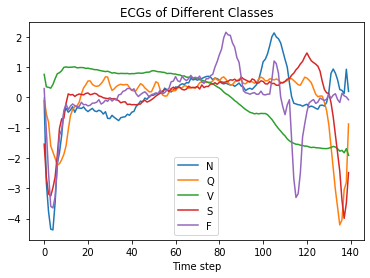

In [2]:
from alibi_detect.datasets import fetch_ecg
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fetch_ecg(return_X_y=True)
y_train -= 1  # classes start at 1
y_test -= 1
x_all = np.concatenate([x_train, x_test], 0)
y_all = np.concatenate([y_train, y_test], 0)

n_total = x_train.shape[0] + x_test.shape[0]
n_class = len(np.unique(y_test))
x_by_class = {c: [] for c in range(n_class)}

# check number of instances per class
for c in range(n_class):
    idx_tr, idx_te = np.where(y_train == c)[0], np.where(y_test == c)[0]
    x_c = np.concatenate([x_train[idx_tr], x_test[idx_te]], axis=0)
    x_by_class[c] = x_c

# plot breakdown of all instances
plt.figure(figsize=(14,7))
labels = ['N','Q','V','S','F']
plt.pie([v.shape[0] for v in x_by_class.values()], labels=labels, 
         colors=['red','green','blue','skyblue','orange'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(plt.Circle((0,0), 0.7, color='white'))
plt.title(f'Breakdown of all {n_total} instances by type of heartbeat')
plt.show()

# visualise an instance from each class
for k, v in x_by_class.items():
    plt.plot(v[0], label=labels[k])
plt.title('ECGs of Different Classes')
plt.xlabel('Time step')
plt.legend()
plt.show()

We can see that most heartbeats can be classified as normal, followed by the unknown class. We will now sample 500 heartbeats to train a simple ECG classifier. Importantly, we leave out the $F$ and $V$ classes which are used to detect drift. First we define a helper function to sample data.

In [3]:
def split_data(x, y, n1, n2, seed=None):
        
    if seed:
        np.random.seed(seed)
    
    # split data by class
    cs = np.unique(y)
    n_c = len(np.unique(y))
    idx_c = {_: np.where(y == _)[0] for _ in cs}

    # convert nb instances per class to a list if needed
    n1_c = [n1] * n_c if isinstance(n1, int) else n1
    n2_c = [n2] * n_c if isinstance(n2, int) else n2
    
    # sample reference, test and held out data
    idx1, idx2 = [], []
    for _, c in enumerate(cs):
        idx = np.random.choice(idx_c[c], size=len(idx_c[c]), replace=False)
        idx1.append(idx[:n1_c[_]])
        idx2.append(idx[n1_c[_]:n1_c[_] + n2_c[_]])
    idx1 = np.concatenate(idx1)
    idx2 = np.concatenate(idx2)    
    x1, y1 = x[idx1], y[idx1]
    x2, y2 = x[idx2], y[idx2]
    return (x1, y1), (x2, y2)

We use a *prop_train* fraction of all samples to train the classifier and then remove instances from the $F$ and $V$ classes. The rest of the data is used by our drift detectors.

In [4]:
prop_train = .15
n_train_c = [int(prop_train * len(v)) for v in x_by_class.values()]
n_train_c[2], n_train_c[4] = 0, 0  # remove F and V classes from the training data
# the remainder of the data is used by the drift detectors
n_drift_c = [len(v) - n_train_c[_] for _, v in enumerate(x_by_class.values())]
(x_train, y_train), (x_drift, y_drift) = split_data(x_all, y_all, n_train_c, n_drift_c, seed=0)
print('train:', x_train.shape, 'drift detection:', x_drift.shape)

train: (731, 140) drift detection: (4269, 140)


## Train an ECG classifier

Now we define and train our classifier on the training set.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, dim_in: int = 140, dim_hidden: int = 128, dim_out: int = 5) -> None:
        super().__init__()
        self.lin_in = nn.Linear(dim_in, dim_hidden)
        self.bn1 = nn.BatchNorm1d(dim_hidden)
        self.lin_hidden = nn.Linear(dim_hidden, dim_hidden)
        self.bn2 = nn.BatchNorm1d(dim_hidden)
        self.lin_out = nn.Linear(dim_hidden, dim_out)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.bn1(self.lin_in(x)))
        x = F.leaky_relu(self.bn2(self.lin_hidden(x)))
        return self.lin_out(x)

In [6]:
from torch.utils.data import TensorDataset, DataLoader
from alibi_detect.models.pytorch.trainer import trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ds_train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train).long())
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, drop_last=True)
model = Classifier().to(device)
trainer(model, nn.CrossEntropyLoss(), dl_train, device, torch.optim.Adam, learning_rate=.001, epochs=5)

Epoch 5/5: 100%|██████████| 22/22 [00:00<00:00, 134.52it/s, loss_ma=0.121]


Let's evaluate out classifier on both the training and drift portions of the datasets.

In [7]:
model.eval()
with torch.no_grad():
    y_pred_train = model(torch.from_numpy(x_train).to(device)).argmax(-1).cpu().numpy()
    y_pred_drift = model(torch.from_numpy(x_drift).to(device)).argmax(-1).cpu().numpy()
acc_train = (y_pred_train == y_train).mean()
acc_drift = (y_pred_drift == y_drift).mean()
print(f'Model accuracy: train {acc_train:.2f} - drift {acc_drift:.2f}')

Model accuracy: train 0.97 - drift 0.94


## Detector calibration under no change

We start with an example where no drift occurs and the reference and test data are both sampled randomly from all classes present in the reference data (classes 0, 1 and 3). Under this scenario, we expect no drift to be detected by either a *normal* MMD detector or by the context-aware MMD detector.

Before we can start using the context-aware drift detector, first we need to **define our context variable**. In our experiments we allow the relative prevalence of subpopulations (i.e. the relative frequency of different types of hearbeats also present in the reference data) to vary while the distributions underlying each of the subpopulations remain unchanged. To achieve this we **condition on the prediction probabilities of the classifier we trained earlier to distinguish the different types of ECGs**. We can do this because the prediction probabilities can account for the frequency of occurrence of each of the heartbeat types (be it imperfectly given our classifier makes the occasional mistake).

In [8]:
from scipy.special import softmax


def context(x: np.ndarray) -> np.ndarray:
    """ Condition on classifier prediction probabilities. """
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(x).to(device)).cpu().numpy()
    return softmax(logits, -1)

In [9]:
from alibi_detect.cd import MMDDrift, ContextMMDDrift
from tqdm import tqdm

n_ref, n_test = 200, 200
n_drift = x_drift.shape[0]

# filter out classes not in training set
idx_filter = np.concatenate([np.where(y_drift == _)[0] for _ in np.unique(y_train)])

n_runs = 100  # number of drift detection runs, each with a different reference and test sample

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    idx = np.random.choice(idx_filter, size=len(idx_filter), replace=False)
    idx_ref, idx_test = idx[:n_ref], idx[n_ref:n_ref+n_test]
    x_ref = x_drift[idx_ref]
    x_test = x_drift[idx_test]
    
    # mmd drift detector
    dd_mmd = MMDDrift(x_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(x_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector 
    c_ref = context(x_ref)
    c_test = context(x_test)
    dd_cad = ContextMMDDrift(x_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(x_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


The below figure of the [Q-Q (Quantile-Quantile) plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) of a random sample from the uniform distribution *U[0,1]* against the obtained p-values from the vanilla and context-aware MMD detectors illustrate how well both detectors are calibrated. A perfectly calibrated detector should have a Q-Q plot which closely follows the diagonal. Only the middle plot in the grid shows the detector's p-values. The other plots correspond to *n_runs* p-values actually sampled from *U[0,1]* to contextualise how well the central plot follows the diagonal given the limited number of samples.

As expected we can see that both the normal MMD and the context-aware MMD detectors are well-calibrated.

In [10]:
import statsmodels.api as sm
from scipy.stats import uniform


def plot_p_val_qq(p_vals: np.ndarray, title: str) -> None:
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(12,10))
    fig.suptitle(title)
    n = len(p_vals)
    for i in range(9):
        unifs = p_vals if i==4 else np.random.rand(n)
        sm.qqplot(unifs, uniform(), line='45', ax=axes[i//3,i%3])
        if i//3 < 2:
            axes[i//3,i%3].set_xlabel('')
        if i%3 != 0:
            axes[i//3,i%3].set_ylabel('')

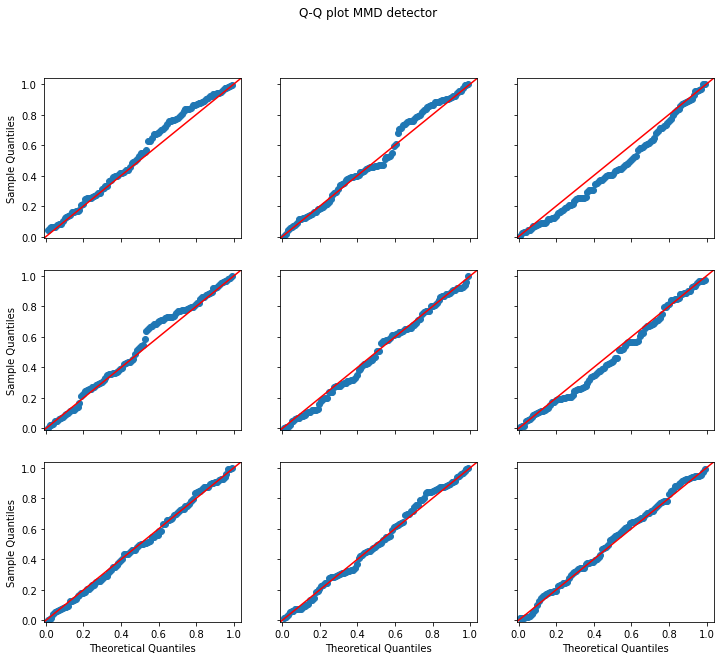

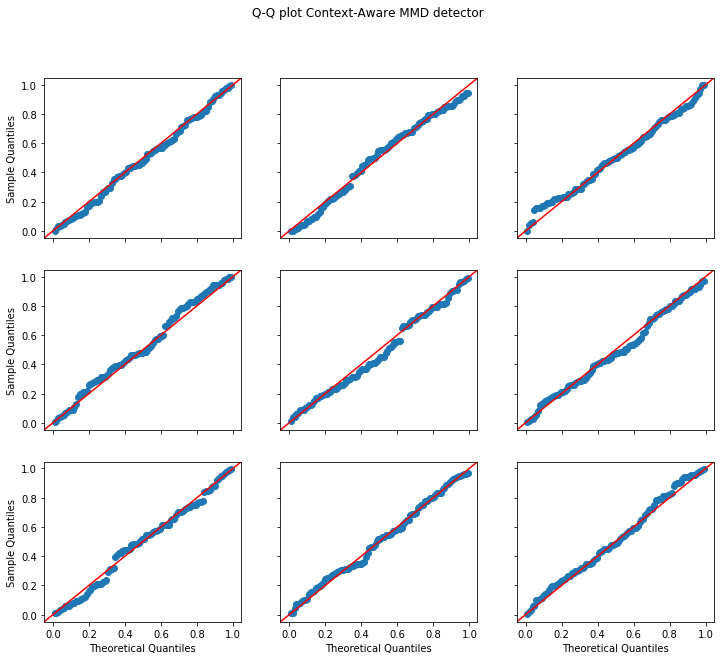

In [11]:
plot_p_val_qq(p_vals_mmd, 'Q-Q plot MMD detector')
plot_p_val_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

## Changing the relative subpopulation prevalence

We now focus our attention on a more realistic problem where the relative frequency of one or more subpopulations (i.e. types of hearbeats) is changing while the underlying subpopulation distribution stays the same. This would be the expected setting when we monitor the heartbeat of a specific person (e.g. only normal heartbeats) and we don't want to flag drift.

In [12]:
n_ref_c = 400
# only 3 classes in train set and class 0 contains the normal heartbeats
n_test_c = [200, 0, 0]

x_c_train, y_c_train = x_drift[idx_filter], y_drift[idx_filter]

n_runs = 100

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    (x_ref, y_ref), (x_test, y_test) = split_data(x_c_train, y_c_train, n_ref_c, n_test_c, seed=_)
    
    # mmd drift detector
    dd_mmd = MMDDrift(x_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(x_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector 
    c_ref = context(x_ref)
    c_test = context(x_test)
    dd_cad = ContextMMDDrift(x_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(x_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


While the usual MMD detector only returns very low p-values (mostly 0), the context-aware MMD detector remains calibrated.

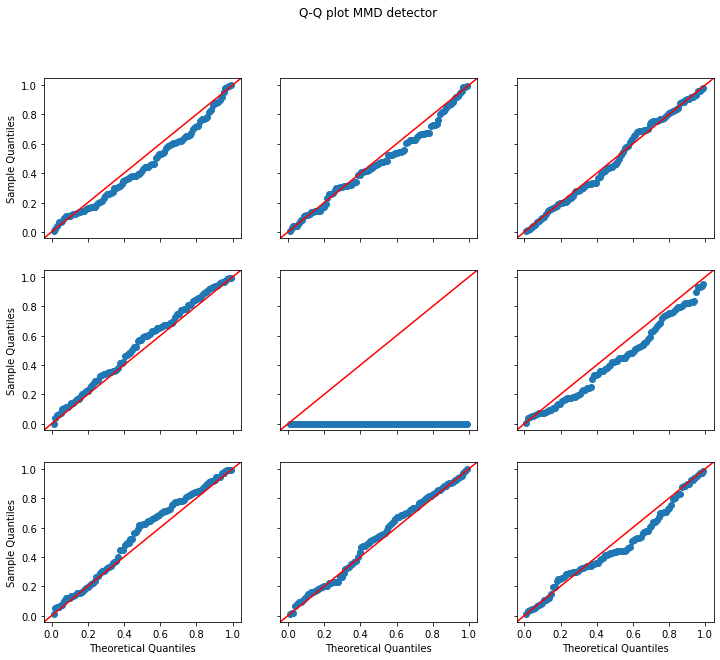

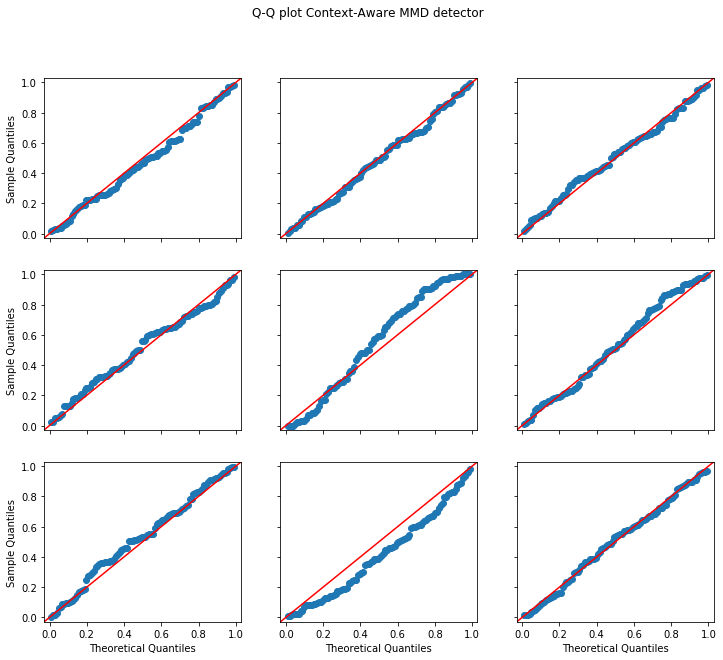

In [13]:
plot_p_val_qq(p_vals_mmd, 'Q-Q plot MMD detector')
plot_p_val_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

## Changing the subpopulation distribution

In the following example we change the distribution of one or more of the underlying subpopulations (i.e. the different types of heartbeats). Notice that now we do want to **flag drift** since our context variable, which permits changes in relative subpopulation prevalences, can no longer explain the change in distribution.

We will again sample from the normal heartbeats, but now we will add random noise to a fraction of the extracted heartbeats to change the distribution. This could be the result of an error with some of the sensors. The perturbation is illustrated below:

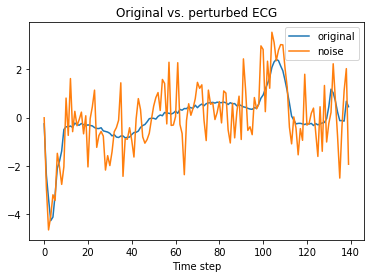

In [14]:
i = 0

plt.plot(x_train[i], label='original')
plt.plot(x_train[i] + np.random.normal(size=140), label='noise')
plt.title('Original vs. perturbed ECG')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [15]:
noise_frac = .4  # 40% of the test set samples are corrupted, the rest stays in-distribution

n_runs = 500

p_vals_cad = []
for _ in tqdm(range(n_runs)):
    
    # sample data
    (x_ref, y_ref), (x_test, y_test) = split_data(x_c_train, y_c_train, n_ref_c, n_test_c, seed=_)
    
    # perturb a fraction of the test data
    n_test, n_features = x_test.shape
    n_noise = int(noise_frac * n_test)
    x_noise = np.random.normal(size=n_noise * n_features).reshape(n_noise, n_features)
    idx_noise = np.random.choice(n_test, size=n_noise, replace=False)
    x_test[idx_noise] += x_noise
    
    # cad drift detector 
    c_ref = context(x_ref)
    c_test = context(x_test)
    dd_cad = ContextMMDDrift(x_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(x_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 500/500 [22:30<00:00,  2.70s/it]


As we can see from the Q-Q and power of the detector, the changes in the subpopulation are easily detected:

Power at 5.0% significance level
Context-aware MMD: 0.954


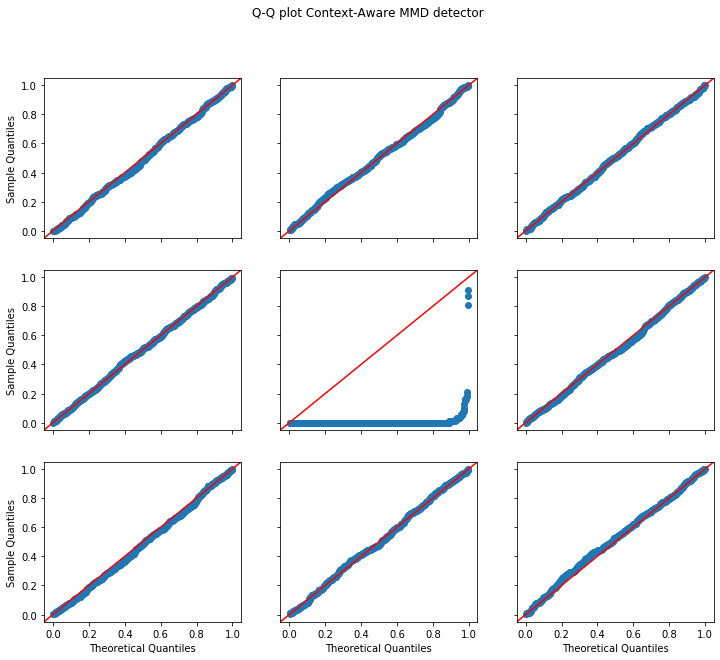

In [16]:
threshold = .05
print(f'Power at {threshold * 100}% significance level')
print(f'Context-aware MMD: {(p_vals_cad < threshold).mean():.3f}')

plot_p_val_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

## Changing the context variable

We now use the cluster membership probabilities of a Gaussian mixture model which is fit on the training instances as context variables instead of the model predictions. We will test both the calibration under no distribution change as well as a change in the prevalence of the subpopulations. Furthermore, we test the power when the $F$ and $V$ heartbeats are included.

In [17]:
from sklearn.mixture import GaussianMixture

n_clusters = len(np.unique(y_train))
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full')
gmm.fit(x_train)

GaussianMixture(n_components=3)

In [18]:
n_ref_c = 400
n_test_c = [100, 100, 10]

n_runs = 100

p_vals_null, p_vals_prev, p_vals_new = [], [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    # no change
    idx = np.random.choice(idx_filter, size=len(idx_filter), replace=False)
    idx_ref, idx_test = idx[:n_ref], idx[n_ref:n_ref+n_test]
    x_ref = x_drift[idx_ref]
    x_test_null = x_drift[idx_test]
    # change subpopulation prevalence
    x_test_prev, y_test_prev = split_data(x_c_train, y_c_train, n_ref_c, n_test_c, seed=_)[1]
    # previously unseen classes
    x_test_new = np.concatenate([x_drift[y_drift == 2], x_drift[y_drift == 4]], 0)
    
    # compute context variables
    c_ref = gmm.predict_proba(x_ref)
    c_test_null = gmm.predict_proba(x_test_null)
    c_test_prev = gmm.predict_proba(x_test_prev)
    c_test_new = gmm.predict_proba(x_test_new)
    
    # detect drift
    dd = ContextMMDDrift(x_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_null = dd.predict(x_test_null, c_test_null)
    preds_prev = dd.predict(x_test_prev, c_test_prev)
    preds_new = dd.predict(x_test_new, c_test_new)
    p_vals_null.append(preds_null['data']['p_val'])
    p_vals_prev.append(preds_prev['data']['p_val'])
    p_vals_new.append(preds_new['data']['p_val'])
    
p_vals_null = np.array(p_vals_null)
p_vals_prev = np.array(p_vals_prev)
p_vals_new = np.array(p_vals_new)

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


Power at 5.0% significance level
Context-aware MMD on F and V classes: 1.000


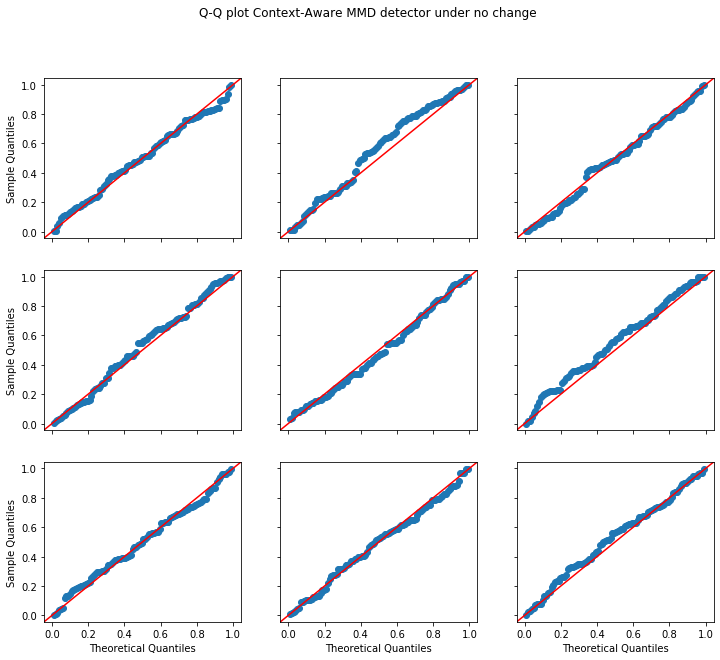

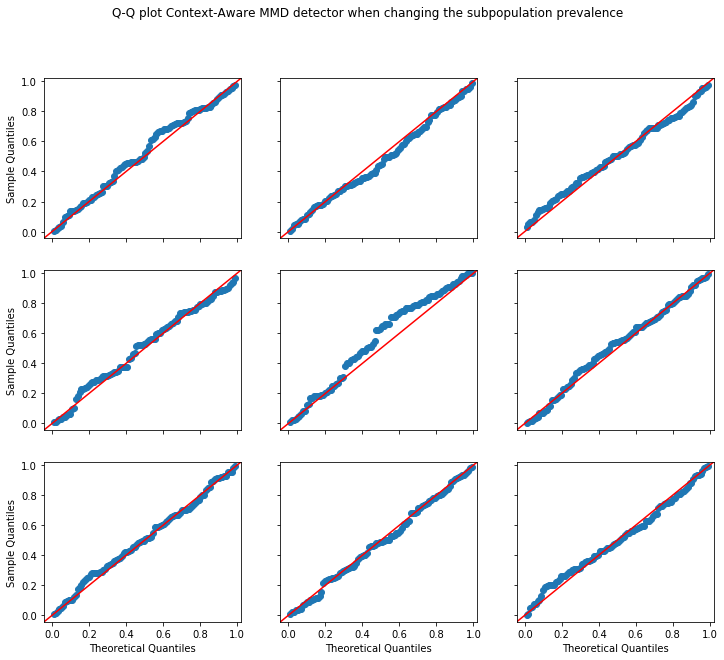

In [19]:
plot_p_val_qq(p_vals_null, 'Q-Q plot Context-Aware MMD detector under no change')
plot_p_val_qq(p_vals_prev, 'Q-Q plot Context-Aware MMD detector when changing the subpopulation prevalence')
threshold = .05
print(f'Power at {threshold * 100}% significance level')
print(f'Context-aware MMD on F and V classes: {(p_vals_new < threshold).mean():.3f}')

## Interpretability of the context-aware detector

The test statistic $\hat{t}$ of the context-aware MMD detector can be formulated as follows: $\hat{t} = \langle K_{0,0}, W_{0,0} \rangle + \langle K_{1,1}, W_{1,1} \rangle -2\langle K_{0,1}, W_{0,1}^{\top}\rangle$ where $0$ refers to the reference data, $1$ to the test data, and $W_{.,.}$ and $K_{.,.}$ are the weight and kernel matrices, respectively. The weight matrices $W_{.,.}$ allow us to focus on the distribution's subpopulations of interest. Reference instances which have similar contexts as the test data will have higher values for their entries in $W_{0,1}$ than instances with dissimilar contexts. We can therefore interpret $W_{0,1}$ as the coupling matrix between instances in the reference and the test sets. This allows us to investigate which subpopulations from the reference set are present and which are missing in the test data. If we also have a good understanding of the model performance on various subpopulations of the reference data, we could even try and use this coupling matrix to roughly proxy model performance on the unlabeled test instances. Note that in this case we would require labels from the reference data and make sure the reference instances come from the validation, not the training set. 

In the following example we only pick 1 type of heartbeat (the normal one) to be present in the test set while 3 types are present in the reference set. We can then investigate via the coupling matrix whether the test statistic $\hat{t}$ focused on the right types of heartbeats in the reference data via $W_{0,1}$. More concretely, we can sum over the columns (the test instances) of $W_{0,1}$ and check which reference instances obtained the highest weights.

In [20]:
n_ref_c = 400
n_test_c = [200, 0, 0]

(x_ref, y_ref), (x_test, y_test) = split_data(x_c_train, y_c_train, n_ref_c, n_test_c)

# condition using the model pred
c_ref = context(x_ref)
c_test = context(x_test)

# initialise detector and make predictions
dd = ContextMMDDrift(x_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
preds = dd.predict(x_test, c_test, return_coupling=True)

# no drift is detected since the distribution of 
# the subpopulations in the test set remain the same
print(f'p-value: {preds["data"]["p_val"]:.3f}')

# extract coupling matrix between reference and test data
W_01 = preds['data']['coupling_xy']

# sum over test instances
w_ref = W_01.sum(1)

p-value: 0.820


As expected no drift was detected since the test set only contains normal heartbeats. We now sort the weights of `w_ref` in descending order. We expect the top 400 entries to be fairly high and consistent since these represent the normal heartbeats in the reference set. Afterwards, the weight attribution to the other instances in the reference set should be low. The plot below confirms that this is indeed what happens.

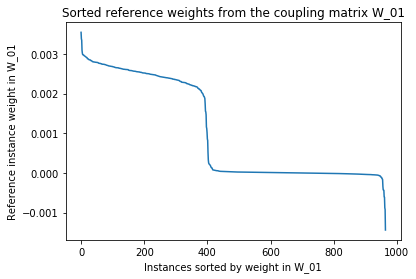

In [21]:
inds_ref_sort = np.argsort(w_ref)[::-1]
plt.plot(w_ref[inds_ref_sort]);
plt.title('Sorted reference weights from the coupling matrix W_01');
plt.ylabel('Reference instance weight in W_01');
plt.xlabel('Instances sorted by weight in W_01');
plt.show()

## Time conditioning

The dataset consists of nicely extracted and aligned ECGs of 140 data points for each observation. However in reality it is likely that we will continuously or periodically observe instances which are not nicely aligned. We could however assign a timestamp to the data (e.g. starting from a peak) and use time as the context variable. This is illustrated in the example below.

First we create a new dataset where we split each instance in slices of non-overlapping ECG segments. Each of the segments will have an associated timestamp as context variable. Then we can check the calibration under no change (besides the time-varying behaviour which is accounted for) as well as the power for ECG segments where we add incorrect time stamps to some of the segments.

In [22]:
# filter out normal heartbeats
idx_normal = np.where(y_drift == 0)[0]
x_normal, y_normal = x_drift[idx_normal], y_drift[idx_normal]
n_normal = len(x_normal)

# determine segment length and starting points in each original ECG
segment_len = 40
n_segments = 3
max_start = n_features - n_segments * segment_len
idx_start = np.random.choice(max_start, size=n_normal, replace=True)

# split original ECGs in segments
x_split = np.concatenate(
    [
        np.concatenate(
            [x_normal[_, idx+i*segment_len:idx+(i+1)*segment_len][None, :] for i in range(n_segments)], 0
        ) for _, idx in enumerate(idx_start)
    ], 0
)

# time-varying context, standardised
c_split = np.repeat(idx_start, n_segments).astype(np.float32)
c_add = np.tile(np.array([i*segment_len for i in range(n_segments)]), len(idx_start)).astype(np.float32)
c_split += c_add
c_split = (c_split - c_split.mean()) / c_split.std()
c_split = c_split[:, None]

In [23]:
n_ref = 500
n_test = 500

mismatch_frac = .4  # fraction of instances where the time stamps are incorrect given the segment
n_mismatch = int(mismatch_frac * n_test)

n_runs = 100

p_vals_null, p_vals_alt = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    # no change
    idx = np.random.choice(n_normal, size=n_normal, replace=False)    
    idx_ref, idx_test = idx[:n_ref], idx[n_ref:n_ref+n_test]
    x_ref = x_split[idx_ref]
    x_test_null = x_split[idx_test]
    x_test_alt = x_test_null
    
    # context
    c_ref, c_test_null = c_split[idx_ref], c_split[idx_test]
    
    # mismatched time stamps
    c_test_alt = c_test_null.copy()
    idx_mismatch = np.random.choice(n_test-1, size=n_mismatch, replace=False)
    c_test_alt[idx_mismatch] = c_test_alt[idx_mismatch+1]  # shift 1 spot to the right
    
    # detect drift
    dd = ContextMMDDrift(x_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_null = dd.predict(x_test_null, c_test_null)
    preds_alt = dd.predict(x_test_alt, c_test_alt)
    p_vals_null.append(preds_null['data']['p_val'])
    p_vals_alt.append(preds_alt['data']['p_val'])
    
p_vals_null = np.array(p_vals_null)
p_vals_alt = np.array(p_vals_alt)

100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


Power at 5.0% significance level
Context-aware MMD with mismatched time stamps: 1.000


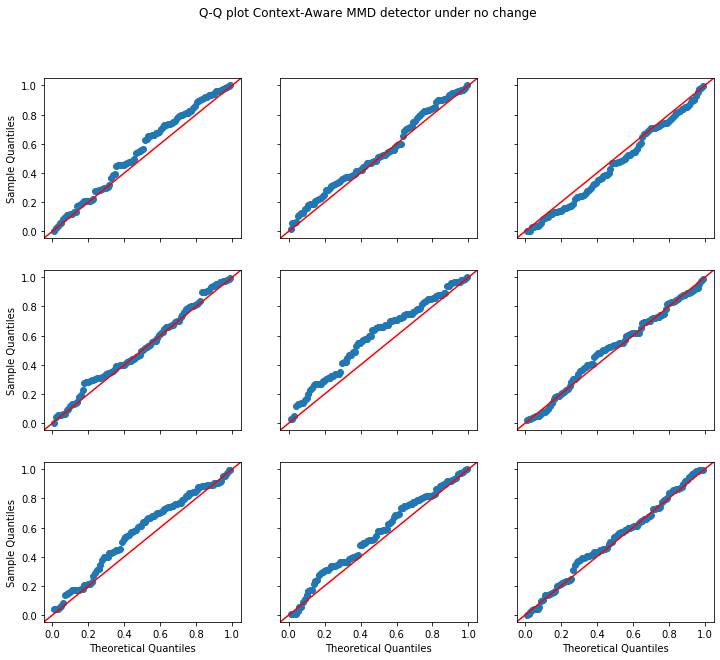

In [24]:
plot_p_val_qq(p_vals_null, 'Q-Q plot Context-Aware MMD detector under no change')
threshold = .05
print(f'Power at {threshold * 100}% significance level')
print(f'Context-aware MMD with mismatched time stamps: {(p_vals_alt < threshold).mean():.3f}')